In [40]:
using Revise

In [42]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2_imbalance.jl")
# working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim"
;

179: 2V (s=6 each)
181: 1V (s=3 each)
182: 3V (s=9 each)
184: 2V (200 particles)
185: 1V (200 particles)
186: 0.5V (200 particles)
187: 0.25V (200)

189: Bayesian optimum  
[0.5, 1.674878459648617, 0.8052808176381836, 2.1839891436085703, 5.683836498117227, 48.433548573835814]

190: Bayesian optimum with 20G/cm
192: s1, s2, s3 = 1

193: optimum with 20G/cm no ramp
194: 192 with no ramp


195: Δ1 = 1.87Γ s1 = 1. s3 = 1. s4 = 2. 20G/cm no ramp
200: same as 195 with displacement 1.0
201: displacement 1.0, larger "discard" radius
202: displacement 0.6
203: s1 = 2. s3 = 2. s4 = 4., displacement=0.6 each
204: s1 = 2. s3 = 2. s4 = 4., no displacement


2:[4.0, 4.0, 4.0, 4.0, 4.0, -5.0, 27.630328075110285] inital 1.5mm cloud
3: same as 204 with 1.5mm cloud

4: [4.0, 4.0, 4.0, 4.0, 4.0, -5.0, 27.630328075110285] inital 0.9mm displaced 0.5mm
This has a large capture range, but higher final temperature and bigger size.

5: same as 204 with 0.9mm cloud displaced by 0.5mm
Smaller capture range, but lower final temperature and smaller final size

6: 4 with half the intensity
Smaller capture range than 4, still high final temperature


9: s1 = 2. s3 = 2. s4 = 4. Δ1 = 1.7Γ Δ3 = 1.7Γ Δ4 = -3.0Γ, 30G/cm, 0.5 displacement
10: 9, no displacement

56: close red
57: Bayesian opt

In [ ]:
same polarization on blue components
opt7: 
test 51 good
test 52 close to optimum

In [29]:

working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim"

i_test = 56
params = load_test_params(working_dir, i_test)
results = load_results(working_dir, i_test);
display_test_info(working_dir, i_test)
@printf("goodness = %.2f", goodness(params.t_end, results))

--------------------------------------------------
test 56 information
--------------------------------------------------
propagation time = 20.00 ms
particle number = 200
--------------------------------------------------
Laser parameters:
Polarizations (+x beam): +, -, +, -
Polarization imbalance: 0.000
Detunings (MHz): 12.80, -25.60, 12.80, -9.60
Saturations: 1.00, 0.00, 1.00, 2.00
Power imbalance (x,y,z): 0.000, 0.000, 0.000
--------------------------------------------------
max B field gradient: (20.00, -20.00, 40.00) G/cm
B field ramp time: 10.0 ms
--------------------------------------------------
Initial state:
Cloud radius = 1.00 mm
Cloud temperature = 0.05 mK
Displacement from centre = (0.00, 0.00, 0.00) mm
Centre of mass velocity = (0.00, 0.00, 0.00) m/s
--------------------------------------------------
Survival: 24 / 200
goodness = 0.10

opt7 
test 35: large capture range slow compression?
test 41: optimum with 3 frequencies
test 45: seems ok

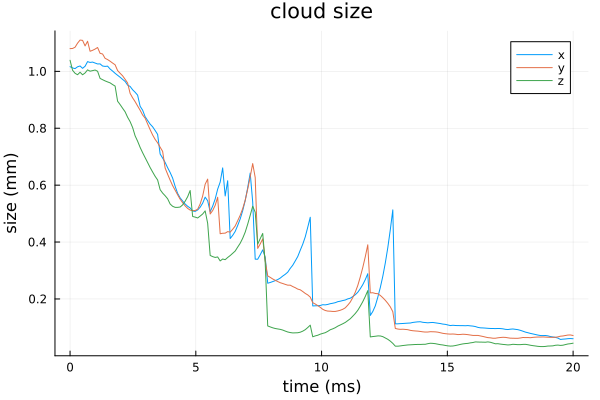

In [19]:
plot_t, σx, σy, σz = plot_size(results, "all")
# savefig(joinpath(working_dir, @sprintf("test%i//size.png", test_i)))
plot!()

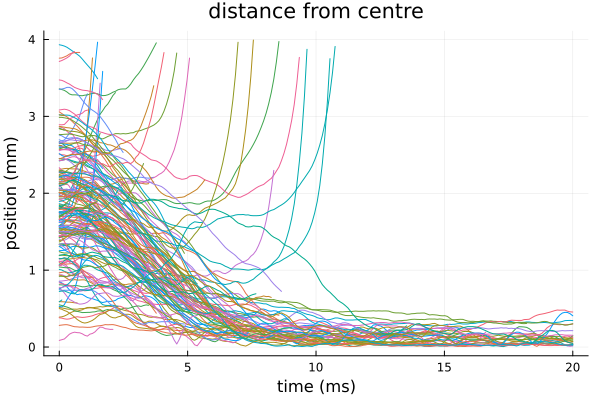

In [30]:
plot_all_trajectories(results, "all")
plot!()

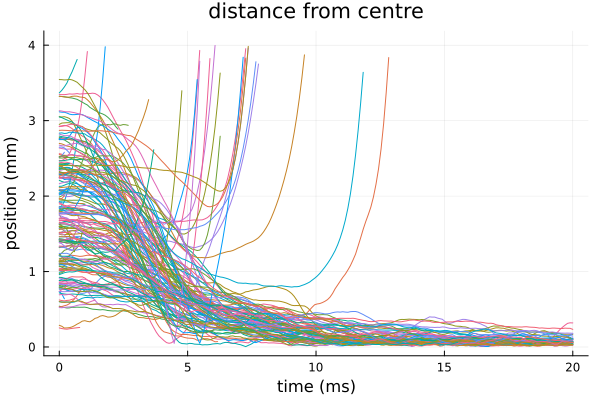

In [20]:
plot_all_trajectories(results, "all")
plot!()

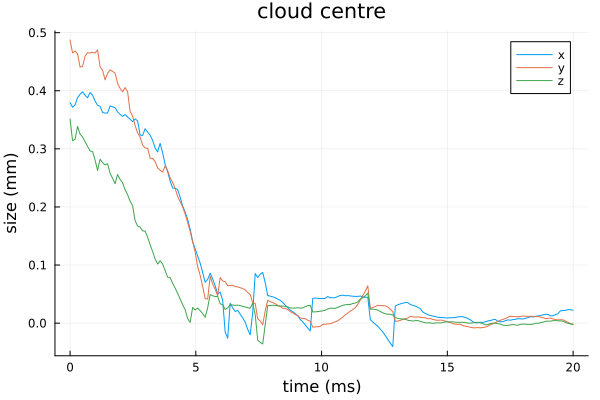

In [21]:
plot_t, plot_x, plot_y, plot_z = plot_centre(results, "all")
# savefig(joinpath(working_dir, @sprintf("test%i//centre.png", test_i)))
plot!()

In [22]:
# plot_all_velocities(results, "z")
# plot!()

T = 50.1 μK

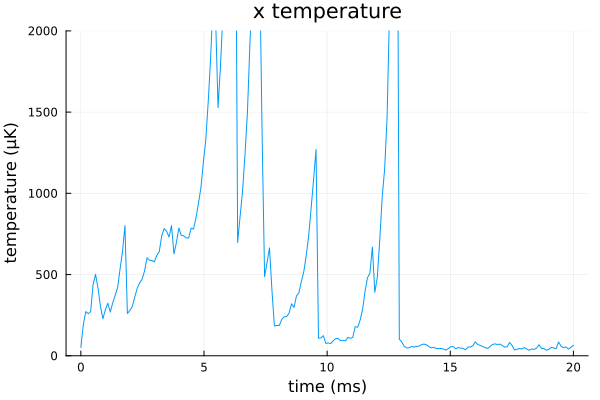

In [23]:
plot_ts, Ts= plot_temperature(results, "x")
@printf("T = %.1f μK", mean(Ts[end-20:end]))
plot!(ylim=(0,2000))

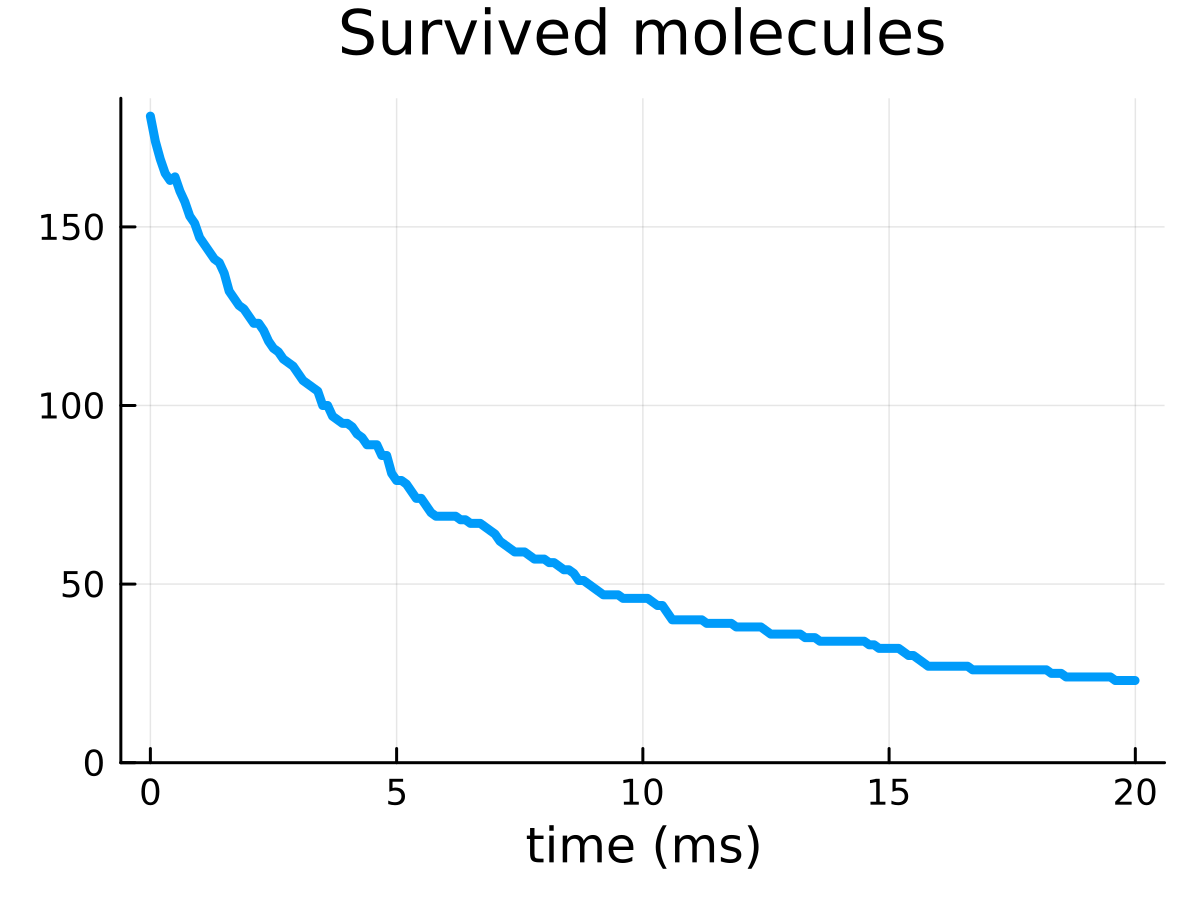

In [39]:
plot_survival(params, results; keep=false, label="")
plot!()

Average scattering rate: 0.89 MHz

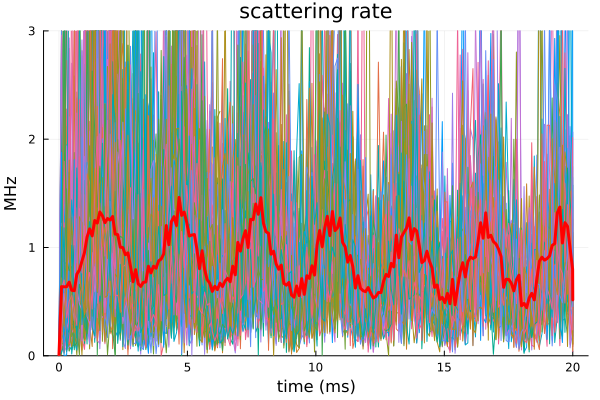

In [25]:
avg_rate = plot_scattering_rate(results)
@printf("Average scattering rate: %.2f MHz", avg_rate)
plot!(ylim=(0,3))

## Plot evolution in XZ plane (integrated along y)

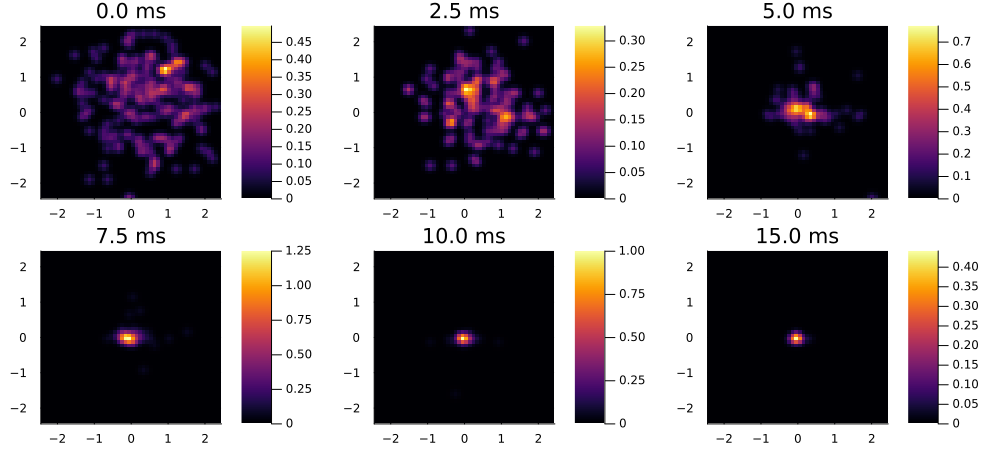

In [37]:
using ImageFiltering

ROI = 16e-3*300/2

img_duration = 0.1
# ROI = 2.0
n_pixels = 50

# ts = [0.0, 2, 4,  8,  12, 20]
ts = [0.0,2.5,5,7.5,10,15]
filter = 1
cmax = 2
plots = []
for t in ts
#     x, z, grids = make_2D_image(results,-ROI,ROI,n_pixels,t=t)
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=3, photon_budget=14000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    push!(plots, heatmap(x,z,imgg', title=@sprintf("%.1f ms", t)))
end
plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6], size=(1000,450))
# savefig(joinpath(working_dir, @sprintf("test%i//camera_images.png", test_i)))
plot!()

## Fit to 2D Gaussian

In [27]:
using Optim

# Define the 2D Gaussian function
function gaussian2d(x, y, p)
    xc, yc, σx, σy, A = p
    return A * exp.(-((x .- xc) .^ 2 / (2 * σx^2) + (y .- yc) .^ 2 / (2 * σy^2)))
end


function least_sq_cost(params)
    predicted = [gaussian2d(xx, zz, params) for xx in x, zz in z]
    return sum((predicted - grids).^2)
end

using Optim
;

# x, z, grids = make_2D_image(results,-2,2,50,t=4)
# xs = repeat(x, 1, length(z))
# zs = repeat(z', length(x),1)
# # Initial parameter guess
# p0 = [0.0, 0.0, 0.4, 0.4, 5.0]
# result = optimize(least_sq_cost, p0);
# p_opt = result.minimizer;
# println(p_opt)
# plot1 = heatmap(x, z, grids', title="data")
# plot2 = heatmap(x, z, gaussian2d(xs, zs, p_opt)', title="fit")
# plot3 = heatmap(x, z, (gaussian2d(xs, zs, p_opt) - grids)', clim=(-5,5), title="residual")
# plot(plot1, plot2, plot3, size=(1000,200), layout=(1,3))

## MOT number and Size

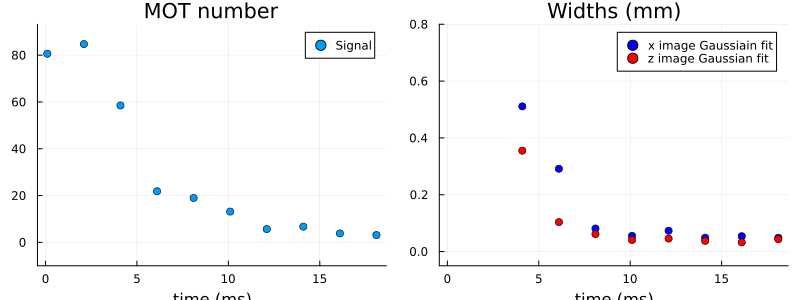

In [38]:
ts = (0.1:2:20)
x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=0, t_img=img_duration, photon_budget=14000)
signal = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, photon_budget=14000)
    push!(signal, sum(grids))
end

# plot_survival(params, results, keep=false, label="actual molecule number")
plot1 = scatter(ts, signal, label="Signal", xlabel="time (ms)", title="MOT number", ylim=(-10,maximum(signal)*1.1), size=(500,400));


σxs = []
x_centres = []
σzs = []
z_centres = []
filter = 0.1

for t in ts
#     x, z, grids = make_2D_image(results,-ROI,ROI,n_pixels,t=t)
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, photon_budget=14000)
    grids = imfilter(grids, Kernel.gaussian(filter))
        
    xs = repeat(x, 1, length(z))
    zs = repeat(z', length(x),1)
    p0 = [0.0, 0.0, 0.4, 0.4, 1.0]
    result = optimize(least_sq_cost, p0);
    p_opt = result.minimizer;
    push!(σxs, abs.(p_opt[3]))
    push!(σzs, abs.(p_opt[4]))
    push!(x_centres, p_opt[1])
    push!(z_centres, p_opt[2])
end
    
plot_ts, σx, σy, σz = plot_size(results, "all")

plot2 = scatter(ts, σxs,color=:blue, linestyle=:dash, label="x image Gaussiain fit")
scatter!(ts, σzs,color=:red, linestyle=:dash, size=(500,400), label="z image Gaussian fit")
# plot!(plot_ts,color=:blue, σx, label="actual σx")
# plot!(plot_ts,color=:red, σz, label="actual σz")
plot!(xlabel="time (ms)", title="Widths (mm)", ylim=(-0.05,0.8));
    
plot!(plot1, plot2, size=(800,300))
# savefig(joinpath(working_dir, @sprintf("test%i//camera_fits.png", test_i)))
plot!()

In [894]:
# using ImageFiltering
# x, z, grids = make_2D_image(results,-4,4,50,t=2)
# # heatmap(z,x,grids, xlabel="z (mm)", ylabel="x (mm)")

# imgg = imfilter(grids, Kernel.gaussian(0.5))
# heatmap(z,x,imgg, xlabel="z (mm)", ylabel="x (mm)")

In [856]:
function get_trapped_indicies(param, results)
   t_max =  param.t_end*1e3
    trapped_indicies = Int[]
    for i in 1:length(results.times)
        if results.times[i][end] ≈ t_max
           push!(trapped_indicies, i) 
        end
    end
    return trapped_indicies
end;

In [36]:
function make_2D_image(results, x_min, x_max, n_pixels;t=0.0,photon_budget=Inf)
    """ grids = population """
    max_t_id = 1
     plot_ts = Float64[]
    for i in 1:length(results.times)
         if length(results.times[i]) > max_t_id
             max_t_id = length(results.times[i])  
             plot_ts = results.times[i]
         end                                                                                                          
     end
   dt = plot_ts[2] - plot_ts[1]
    it = Int(t ÷ dt) + 1

    grids = zeros(n_pixels, n_pixels)
    x = LinRange(x_min, x_max, n_pixels)
    dx = x[2]-x[1]
    z = LinRange(x_min, x_max, n_pixels)
    for i in 1:length(results.times)
        if it > length(results.times[i])
            continue
        end
        x_end = results.x_trajectories[i][it]
        z_end = results.z_trajectories[i][it]
        n_photons = sum(results.A_populations[i][1:it]*dt*Γ/1000)
       if  (x_min < x_end < x_max) && (x_min < z_end < x_max)
           ix = Int((x_end - x_min) ÷ dx + 1)
            iz = Int((z_end - x_min) ÷ dx + 1)
            grids[ix, iz] += 1 * exp(-n_photons / photon_budget)
        end
    end
    return x, z, grids
end

function take_camera_image(results, x_min, x_max, n_pixels;t=0.0, t_img=0.0, const_scattering=false, noise=0.0,photon_budget=Inf)
    x, z, grids = make_2D_image(results, x_min, x_max, n_pixels;t=t, photon_budget=photon_budget)
    dt = 0.5
    if const_scattering
        grids = grids .* dt 
    else
        grids = grids .* scattering_rate_at_t(results, t+0.1) * dt 
    end
    if t_img <= 0.5
        return x, z, grids
    else
        t_curr = t + dt
        while t_curr < t + t_img
            ~,~,grids1 = make_2D_image(results, x_min, x_max, n_pixels;t=t_curr, photon_budget=photon_budget)
            if const_scattering
                grids = grids .+ grids1 * dt
            else
                grids = grids .+ grids1 * scattering_rate_at_t(results, t_curr) * dt
            end
            t_curr += dt
        end
        grids = grids .+ (rand(length(x), length(z)).- 0.5).*t_img * noise
        return x, z, grids # grids = brightness
    end
end

take_camera_image (generic function with 1 method)

In [ ]:
## For Bayesian optimization

In [33]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        if r > 1.0
            n += 0.0
        elseif r > 0.5
            n += 0.1 * exp(-results.photons_scattered[survived_idx]/14000)
        elseif r > 0.3
            n += (0.6 - r)* exp(-results.photons_scattered[survived_idx]/14000)
        elseif r <= 0.3
            n += ((0.3 - r) * 3 + 0.3) * exp(-results.photons_scattered[survived_idx]/14000)
        end
    end
    return n/n_molecules
end
;

"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = Δ1
    Δ4 = x[5]*Γ
    ramp_time = 5*1e-3
    B_gradient = -x[6]

    temp = @with_unit 0.050 "mK"
    diameter = @with_unit 0.6 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end=15e-3, n_values=60,
        pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁺, pol4_x=σ⁻, 
        s1=s1, s2=0.0, s3=s3, s4=s4,
        Δ1=Δ1, Δ2=0.0, Δ3=Δ3, Δ4=Δ4,
        B_gradient=-45,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time=ramp_time,
        pol_imbalance=0.05, s_imbalance = (0.0, 0.0, 0.0))
    
    results = simulate_particles_v3(package, params)
    
    @printf("s1 = %.2f, s3 = %.2f, s4 = %.2f, Δ1 = Δ3 = %.2f Γ, Δ4 = %.2f Γ, ramp over %.1f ms",x[1], x[2], x[3], x[4], x[5], x[6])
    println()
    
    _goodness = goodness(params.t_end, results)
#     println(results.photons_scattered)
    
    @printf("goodness = %.1f", _goodness)
    println()
    
    return _goodness
end
;    

In [6]:
using BayesianOptimization, GaussianProcesses
using Serialization
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\opt7"
# opt = deserialize(joinpath(working_dir, "opt_constrained_red_freq1.jl"))
opt = deserialize(joinpath(working_dir, "opt_flip_pol2.jl"))

Bayesian Optimization object

model:
GP Exact object:
  Dim = 5
  Number of observations = 600
  Mean function:
    Type: MeanConst, Params: [0.022806265416017074]
  Kernel:
    Type: SEArd{Float64}, Params: [1.272765022223479, 1.195193695602533, 2.075804110287788, 0.31615085815458566, 1.500087522120333, -3.5861909976621313]
  Input observations = 
[1.015625 3.765625 … 5.956006500754127 4.564069698364077; 3.078125 5.828125 … 4.058658082945055 2.6338431664603137; … ; 4.109375 1.359375 … 0.5978792266086794 4.800959355528491; -5.3125 -2.3125 … -5.2371540521612605 -4.710542889171331]
  Output observations = [0.001, 0.03628037694915413, 0.04639490489679885, 0.09318652964631609, 0.062253018468098366, 0.0, 0.049162576212861936, 0.008177615569600163, 0.004, 0.016791889374812567  …  0.0563760970424394, 0.059458436410493185, 0.015767689207212388, 0.06937012395906875, 0.09272539295673499, 0.05017199466261221, 0.04316390403774539, 0.03526995973440182, 0.04058032707025517, 0.04119892887991294]
  Va


acquisition:


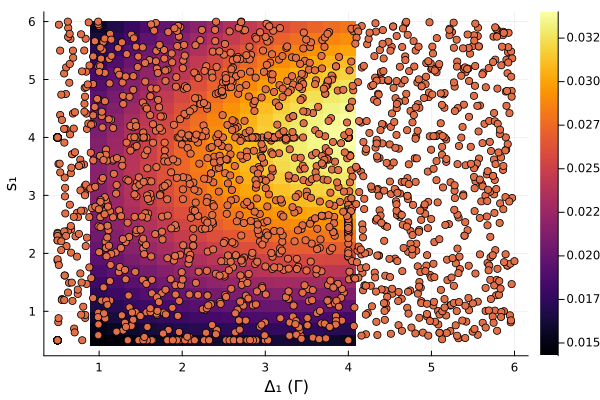

In [431]:
idx1 = 1
idx2 = 4

lists = [0.5:0.2:6, 0.5:0.2:6, 0.0:0.2:6, 1.0:0.2:4.0,1.0:0.2:4, -5:0.2:1.0, 10:1:50]
list1 = lists[idx1]
list2 = lists[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(7, 1)

labels = Dict(1=>"s₁", 2=>"s₃", 3=>"s₄", 4=>"Δ₁ (Γ)", 5=>"Δ₃ (Γ)", 6=>"Δ₄ (Γ)", 7=>"B Gradient (G/cm)")

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel=labels[idx2], ylabel=labels[idx1])
scatter!(opt.model.x[idx2,:], opt.model.x[idx1,:], legend=nothing)

### Animation

In [368]:
using Plots

results = results1
# Number of frames in the animation
num_frames = 120
saving_dir = working_dir
# Initialize random points
points = get_points_from_results(results, 1)
dt = results.times[1][2] - results.times[1][1]

# Create a function to update the positions of points in each frame
function update_points(points, num_frames)
    anim = Animation()
    for f in 1:num_frames
        # Update the position of each point randomly
        points = get_points_from_results(results, f)
        
        # Create a 3D scatter plot
        scatter3d([p[1] for p in points], [p[2] for p in points], [p[3] for p in points],
            legend=false, xlim=[-2,2], ylim=[-2,2], zlim=[-2,2], dpi=200)
        
        # Set axis labels
        xlabel!("x (mm)")
        ylabel!("y (mm)")
        zlabel!("z (mm)")
        
        # Set the title for each frame
        title!(@sprintf("t = %.0f ms", f * dt))
        
        frame(anim)
    end
    return anim
end

# Create the animation
animation = update_points(points, num_frames)

# Define the filename and save the animation as an MP4 video
filename = joinpath(saving_dir, "animation_2freq_subopt.mp4")
mp4(animation, filename)

# Alternatively, you can save it as a GIF (may require additional libraries)
# filename = "trajectory_animation.gif"
# gif(animation, filename)

println("Animation saved as $filename")


Animation saved as scan7\animation_2freq_subopt.mp4


[ Info: Saved animation to G:\My Drive\github\OpticalBlochEquations\examples\ipynb_sources\toy_models\CaOH_scan\scan7\animation_2freq_subopt.mp4
